In [348]:
import pandas as pd # data processing
import numpy as np # linear algebra
import random
#import cv2
from PIL import Image
import matplotlib as mpl
from nltk.corpus import stopwords
from scipy.misc import imread
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
from os import path
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

In [163]:
%matplotlib inline
plt.rcParams["figure.figsize"]=(12,6)

In [164]:
df=pd.read_csv('~/Desktop/proj1/data/lyrics.csv')

In [165]:
#load the processed lyrics data which has the stemmed words
processed=pd.read_csv('~/Desktop/proj1/data/processed_lyrics.csv')
#processed=processed.drop('Unnamed: 0')

In [166]:
df.head()

,song,year,artist,genre,lyrics
0,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home\nIt ...
1,careless-whisper,2009,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...
2,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...
3,power-of-desire,2007,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...
4,you-re-not-in-love,2007,a,Hip-Hop,something in the way we touch\nyou hold my han...


In [167]:
#let's see which years were recorded
df.year.unique()

array([2009, 2007, 2013, 2005, 2012, 2002, 1997, 2000, 2008, 2016, 2006,
       2010, 2011, 2015, 2014, 1998, 1996, 1990, 2004, 2003, 2001, 1994,
       1977, 1995, 1981, 1982, 1992, 1986, 1989, 1978, 1999, 1972, 1983,
       1980, 1975, 1976, 1985, 1984, 1988, 1991, 1973, 1971, 1993, 1974,
       1987, 1970, 1979,  702,  112, 1968])

In [168]:
#we found the dataset has two misinput value: year 702 and year 112
#let's take a closer look songs in those two years
years=[112, 702]
df.loc[df['year'].isin(years)]
#702 the song 'star' was published in 2003 & 112 the song 'anywhere-remix' was published in 1998

,song,year,artist,genre,lyrics
64363,star,702,clipse,Hip-Hop,You're my star\nIt's such a wonder how you shi...
91139,anywhere-remix,112,dru-hill,Hip-Hop,"Here we are all alone\nYou and me, privacy\nAn..."


In [169]:
#we then assigned the correct year to those two songs
df.year[df.year==702]=2003

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [170]:
df.year[df.year==112]=1998

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [171]:
df.artist[df.artist=='bone-thugs']='bone-thugs-n-harmony'

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [172]:
#check if the two songs published years were changed
df.loc[[64363, 91139], :]

,song,year,artist,genre,lyrics
64363,star,2003,clipse,Hip-Hop,You're my star\nIt's such a wonder how you shi...
91139,anywhere-remix,1998,dru-hill,Hip-Hop,"Here we are all alone\nYou and me, privacy\nAn..."


In [173]:
#replace carriage returns
df = df.replace({'\n': ' '}, regex=True)

In [174]:
#count the words in each song
df['word_count'] = df['lyrics'].str.split().str.len()

In [175]:
def decade(c):
    if 1950 <= c and c < 1960:
        return 1950
    elif 1960 <= c and c < 1970:
        return 1960
    if 1970 <= c and c < 1980:
        return 1970
    elif 1980 <= c and c < 1990:
        return 1980
    elif 1990 <= c and c < 2000:
        return 1990
    elif 2000 <= c and c < 2010:
        return 2000
    return 2010

df['year'] = df['year'].apply(int, 1)
df['decade'] = df['year'].apply(decade)
df.head()

,song,year,artist,genre,lyrics,word_count,decade
0,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home It w...,107,2000
1,careless-whisper,2009,a,Hip-Hop,I feel so unsure As I take your hand and lead ...,300,2000
2,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,369,2000
3,power-of-desire,2007,a,Hip-Hop,[Chris:] Fallin' for a fantasy I threw away my...,147,2000
4,you-re-not-in-love,2007,a,Hip-Hop,something in the way we touch you hold my hand...,125,2000


In [176]:
#check the word count by genre
df['word_count'].groupby(df['genre']).describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Country,7534.0,191.079241,81.972874,38.0,131.0,176.0,235.0,1336.0
Electronic,2815.0,203.307993,120.545836,21.0,119.0,179.0,256.5,1380.0
Folk,514.0,222.509728,154.269798,48.0,138.0,194.5,264.0,2393.0
Hip-Hop,8905.0,529.317799,237.583855,37.0,369.0,521.0,672.0,4328.0
Indie,1318.0,196.591047,87.367414,43.0,133.0,184.0,245.0,703.0
Jazz,4123.0,167.331070,88.356146,36.0,107.0,146.0,204.0,1040.0
Metal,11311.0,188.897622,106.526189,31.0,119.0,170.0,235.0,2423.0
Not Available,3325.0,222.858647,109.933178,28.0,145.0,205.0,277.0,1423.0
Other,147.0,260.210884,159.264587,55.0,126.0,212.0,363.0,795.0


In [177]:
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0], df.shape[1]))
print("There are {} genres of music in this dataset such as {}... \n".format(len(df.genre.unique()),
                                                                            ", ".join(df.genre.unique()[0:5])))
print("There are {} artists recorded in this dataset such as {}... \n".format(len(df.artist.unique()),
                                                                             ", ".join(df.artist.unique()[0:5])))

There are 125715 observations and 7 features in this dataset. 

There are 12 genres of music in this dataset such as Hip-Hop, Other, Pop, Metal, Rock... 

There are 2534 artists recorded in this dataset such as a, a-boogie-wit-da-hoodie, a-camp, a-canorous-quintet, a-change-of-pace... 



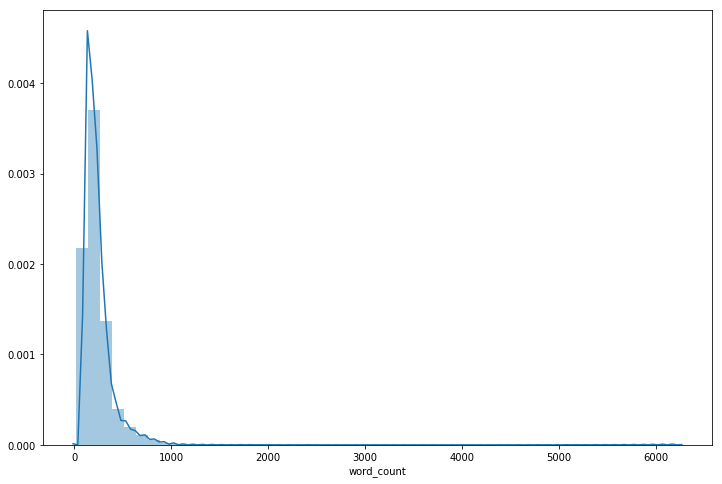

In [178]:
#check the word_count distribution
sns.distplot(df['word_count'])

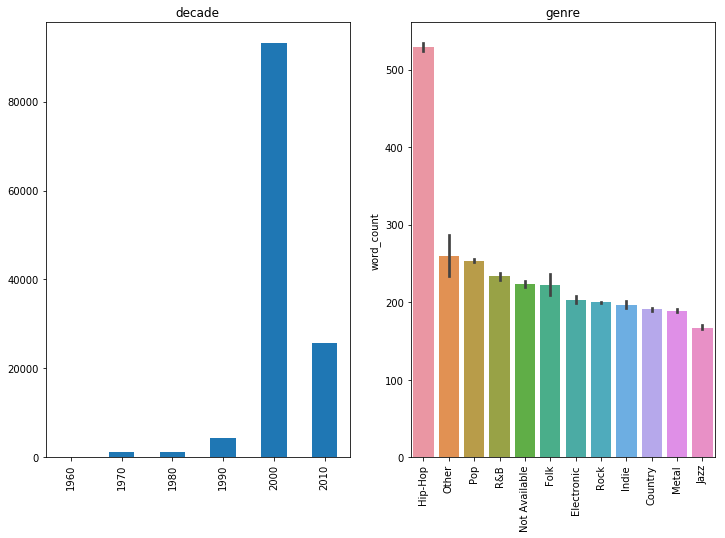

In [204]:
# Set up a subplot grid that has height 1 and width 3,
# and set the first such subplot as active.
plt.subplot(1, 2, 1)

# Make the first plot
df.groupby(['decade']).aggregate({'decade':'count'}).sort_index(ascending=True)['decade'].plot.bar()
plt.title('decade')
plt.xlabel('')

# Set the second subplot as active, and make the second plot.
plt.subplot(1, 2, 2)
result = df.groupby(["genre"])['word_count'].mean().reset_index().sort_values("word_count", ascending=False)
sns.barplot(x="genre", y="word_count", data=df, order=result["genre"])
plt.title('genre')
plt.xlabel('')
plt.xticks(rotation=90)

# Show the figure.
plt.show()

Before digging into the details of genre/artist differences, let's first take a look at the song productivity of decades from 1960s to 2010s. Here we can see that the 2000-2010 produced most songs, but that might due to collection problem. 


In [351]:
#top 5 most productive artists
#df.groupby(["artist", "genre"])['word_count'].mean().reset_index().sort_values("word_count", ascending=False)
#df.loc[df['artist']=='dolly-parton']
#top5
#count >=10 & groupby artist [word_count]

#df_artist = df.groupby(['artist']).aggregate({
#    'artist':['count']  
#})
#top6 = df_artist.sort_values([('artist','count')], ascending=False).head(6)
#top6
#df.loc[[64363, 91139], :]
#df.groupby(['artist']).count() <10
#df.loc[df.groupby(['artist']).count()>=10,:]
#df.loc[df.groupby(['artist']).count()>=10]
#df.loc[df.artist.isin[()]
#df.loc[df.artist.isin(df_artist['artist'])]
#df['song_count']=
#df
#top6=
#df.loc[[64363, 91139], :]
df.groupby(['artist', 'genre']).count().sort_values("song", ascending=False).head(5)[[ "song"]]
#df_clean["artist"].value_counts()
#result = df.groupby(["genre"])['word_count'].mean().reset_index().sort_values("word_count", ascending=False)
#df.groupby["artist"].count()#.sort_values(ascending=False).head(6)

,,song
artist,genre,
dolly-parton,Country,717
elton-john,Rock,619
chris-brown,Hip-Hop,596
bee-gees,Pop,577
bob-dylan,Rock,563


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

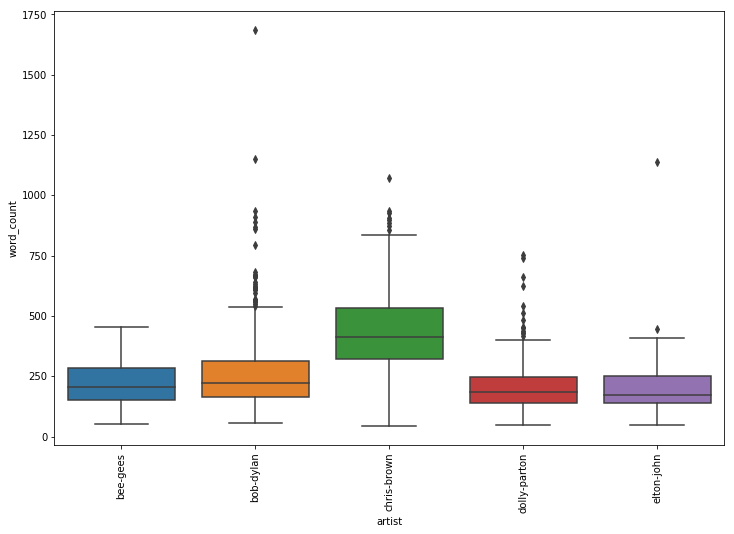

In [316]:
artists=['dolly-parton','elton-john', 'chris-brown','bee-gees', 'bob-dylan']
top_5=df.loc[df['artist'].isin(artists)]
sns.boxplot(x="artist", y="word_count", data=top_5)
plt.xticks(rotation=90)

#Do musicians complain more or instruct more? If complaining, what do they hate?

#To get more details about the lyrics text of the 10 most eloquent artist, I created 10 corresponding wordclouds.

In [302]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["lot", "wanna", "wouldnt", "wasnt", "ha", "na", "ooh", "da",
        "gonna", "im", "dont", "aint", "wont", "yeah", "la", "oi", "nigga", "ya", "aah", "ye", "hey", 
        "ba", "da", "buh", "duh", "doo", "oh", "ooh", "woo", "uh", "hoo", "ah", "yead", "oo", "chorus", "beep", 
          "hey", "last", "past", "feel", "youre", "ll", "ve", "don"])

In [303]:
#lyrics group by artist
def ofString(s):
    s= s.lower()
    s= s.replace('\n', ' ')
    s= s.replace(',', ' ')
    s= s.replace('\'', ' ')
    return s

In [304]:
def allTextByArtist(df):
    D={}
    for ind,val in df.iterrows():
        art = val["artist"]
        if art in D:
            D[art]= D[art]+ ofString(str(val["lyrics"]))
        else:
            D[art]= ofString(str(val["lyrics"]))
    return D

In [305]:
D= allTextByArtist(df)

In [308]:
def drawCloud(s):
    wordclouddd = WordCloud(background_color="white",max_words=150,stopwords=stopwords).generate(s)
    #fig = plt.figure()
    #fig.set_figwidth(17)
    #fig.set_figheight(10)

    
    #plt.title('GG', color='#fafafa', size=30, y=1.01)
    #plt.annotate('GG', xy=(0, -.025), xycoords='axes fraction', fontsize=12, color='#fafafa')
    
    plt.imshow(wordclouddd)
    plt.axis("off")
    plt.figure()
    #plt.imshow(hcmask, cmap=plt.cm.gray)
    #plt.axis("off")
    #plt.show()

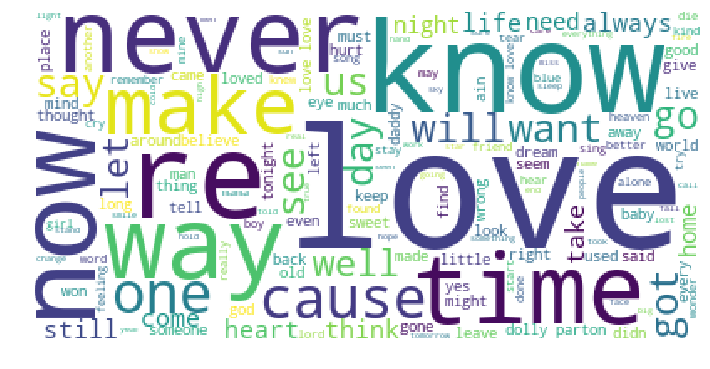

<Figure size 864x576 with 0 Axes>

In [309]:
drawCloud(D['dolly-parton'])

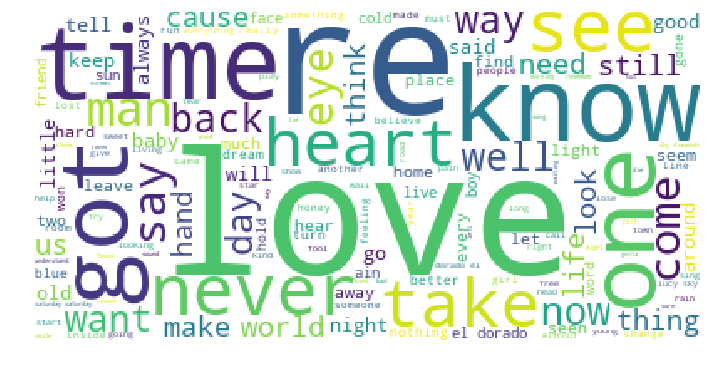

<Figure size 864x576 with 0 Axes>

In [310]:
drawCloud(D['elton-john'])

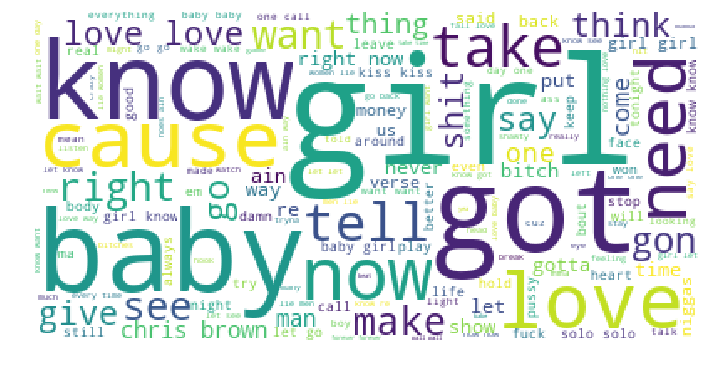

<Figure size 864x576 with 0 Axes>

In [311]:
drawCloud(D['chris-brown'])

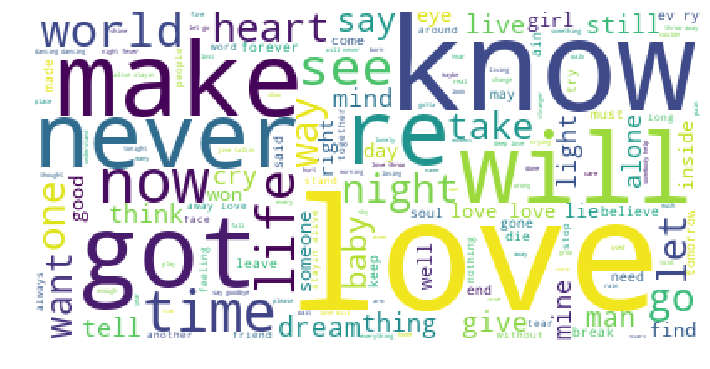

<Figure size 864x576 with 0 Axes>

In [312]:
drawCloud(D['bee-gees'])

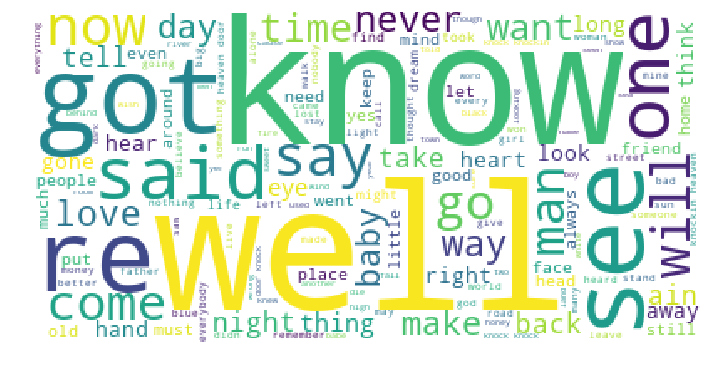

<Figure size 864x576 with 0 Axes>

In [313]:
drawCloud(D['bob-dylan'])

In [352]:
girl = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('girl')].count()))
girl.reset_index(inplace=True)
girl.columns = ['genre', 'girl_lyrics']
girl

,genre,girl_lyrics
0,Country,989
1,Electronic,249
2,Folk,58
3,Hip-Hop,3024
4,Indie,101
5,Jazz,365
6,Metal,249
7,Not Available,402
8,Other,25
9,Pop,3197


In [360]:
love = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('love')].count()))
love.reset_index(inplace=True)
love.columns = ['genre', 'love_lyrics']
love

,genre,love_lyrics
0,Country,4047
1,Electronic,1061
2,Folk,207
3,Hip-Hop,4117
4,Indie,507
5,Jazz,2428
6,Metal,2001
7,Not Available,1491
8,Other,80
9,Pop,10267


In [361]:
baby = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('baby')].count()))
baby.reset_index(inplace=True)
baby.columns = ['genre', 'baby_lyrics']
baby

,genre,baby_lyrics
0,Country,934
1,Electronic,350
2,Folk,35
3,Hip-Hop,2754
4,Indie,78
5,Jazz,613
6,Metal,247
7,Not Available,564
8,Other,40
9,Pop,4172


In [356]:
genre = df.groupby(['genre'],as_index=False).count()
genre2 = genre[['genre','song']]

In [363]:
import functools
dfs = [genre2,girl, love, baby]
genre3 = functools.reduce(lambda left,right: pd.merge(left,right,on='genre', how='outer'), dfs)
genre3['girl_ratio'] = genre3['girl_lyrics'] / genre3['song']
genre3['love_ratio'] = genre3['love_lyrics'] / genre3['song']
genre3['baby_ratio'] = genre3['baby_lyrics'] / genre3['song']
genre3

,genre,song,girl_lyrics,love_lyrics,baby_lyrics,girl_ratio,love_ratio,baby_ratio
0,Country,7534,989,4047,934,0.131272,0.537165,0.123971
1,Electronic,2815,249,1061,350,0.088455,0.376909,0.124334
2,Folk,514,58,207,35,0.112840,0.402724,0.068093
3,Hip-Hop,8905,3024,4117,2754,0.339585,0.462325,0.309264
4,Indie,1318,101,507,78,0.076631,0.384674,0.059181
5,Jazz,4123,365,2428,613,0.088528,0.588892,0.148678
6,Metal,11311,249,2001,247,0.022014,0.176907,0.021837
7,Not Available,3325,402,1491,564,0.120902,0.448421,0.169624
8,Other,147,25,80,40,0.170068,0.544218,0.272109
9,Pop,18698,3197,10267,4172,0.170981,0.549096,0.223125


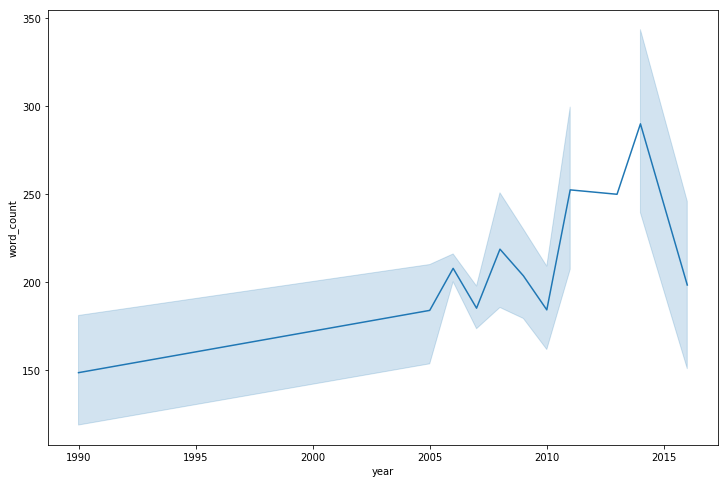

In [336]:
sns.lineplot(x="year", y="word_count", data=top_5[top_5['artist']=='dolly-parton'])
plt.xlabel('dolly-parton')

Text(0.5, 0, 'elton-john')

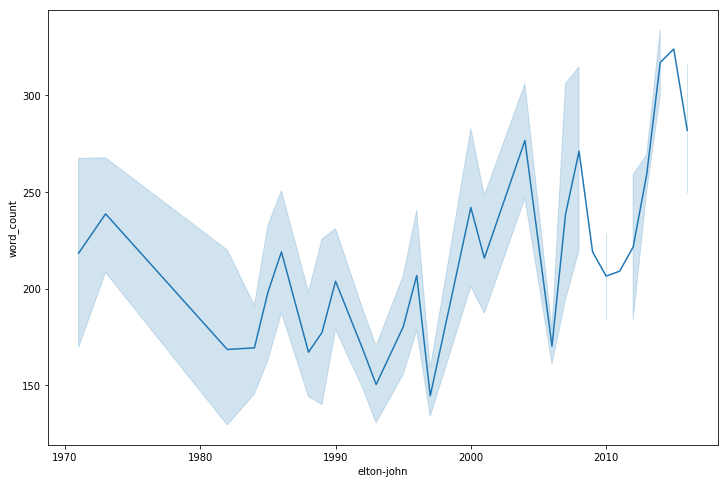

In [359]:
sns.lineplot(x="year", y="word_count", data=top_5[top_5['artist']=='elton-john'])
plt.xlabel('elton-john')

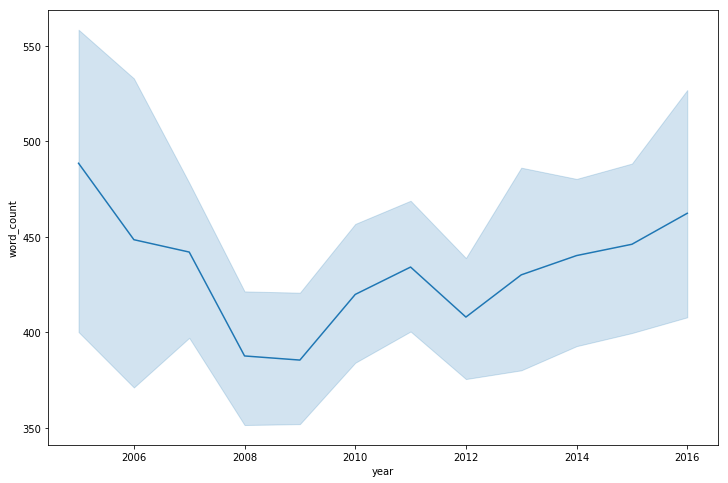

In [338]:
sns.lineplot(x="year", y="word_count", data=top_5[top_5['artist']=='chris-brown'])
plt.xlabel('chris-brown')

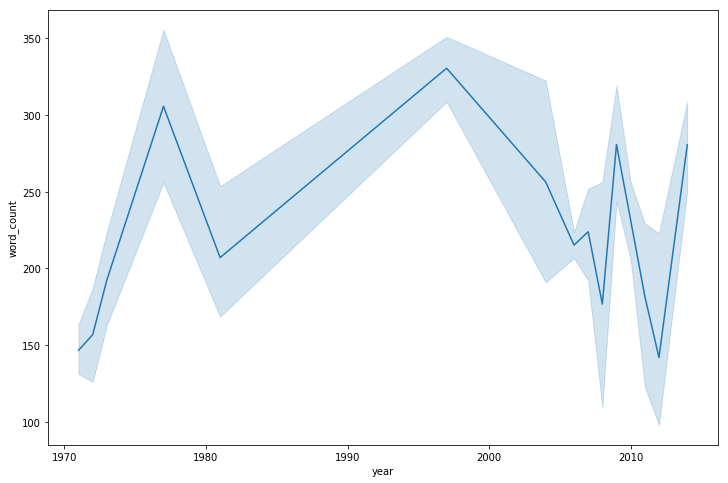

In [339]:
sns.lineplot(x="year", y="word_count", data=top_5[top_5['artist']=='bee-gees'])
plt.xlabel('bee-gees')

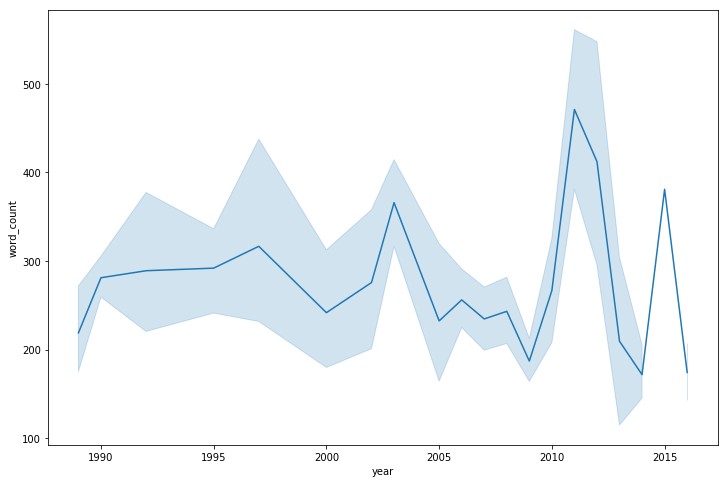

In [329]:
sns.lineplot(x="year", y="word_count", data=top_5[top_5['artist']=='bob-dylan'])
plt.xlabel('bob-dylan')